In [ ]:
import networkx as nx
import osmnx as ox
import nx_arangodb as nxadb

import os 

from arango import ArangoClient

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

In [ ]:
credentials = yaml.load(open('credentials.yml'))
os.environ["OPENAI_API_KEY"] = credentials["OPENAI_API_KEY"]


In [ ]:

db = ArangoClient(hosts=credentials["DATABASE_HOST"]).db(username=credentials["DATABASE_USERNAME"], password=credentials["DATABASE_PASSWORD"], verify=True)
print(db)

<StandardDatabase _system>


In [27]:
G_fh = ox.graph_from_place('Forest Hills, Queens, NY',simplify=True)

In [28]:
for n1, n2, d in G_fh.edges(data=True):
    d.pop('geometry', None)

In [29]:
print(G_fh)

MultiDiGraph with 3666 nodes and 11199 edges


In [30]:
G_fh_nxadb = nxadb.MultiDiGraph(name="Forest_Hills",
                                db=db,
                                incoming_graph_data=G_fh,
                                overwrite_graph=True)

print(G_fh_nxadb)

[17:32:21 -0500] [INFO]: Graph 'Forest_Hills' created.
[2025/02/24 17:32:21 -0500] [95569] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database '_system'


Output()

Output()

[2025/02/24 17:32:22 -0500] [95569] [INFO] - adbnx_adapter: Created ArangoDB 'Forest_Hills' Graph


MultiDiGraph named 'Forest_Hills' with 3666 nodes and 0 edges


In [31]:
print(G_fh_nxadb.number_of_edges())
print(G_fh.number_of_edges())

11199
11199


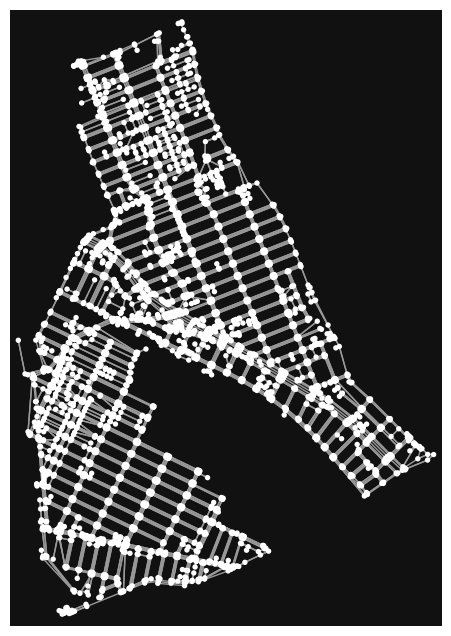

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [32]:
ox.plot_graph(G_fh)

In [34]:
arango_graph = ArangoGraph(db)

In [ ]:
import os
llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
llm.invoke("hello!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-9ca810bc-003b-4f31-8a5d-700b15dac323-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [36]:
@tool
def text_to_aql_to_text(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=arango_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )
    
    result = chain.invoke(query)

    return str(result["result"])

In [37]:
# 5. Define the Text to NetworkX/cuGraph Tool
# Note: It is encouraged to experiment and improve this section! This is just a placeholder:

@tool
def text_to_nx_algorithm_to_text(query):
    """This tool is available to invoke a NetworkX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

    ######################
    print("1) Generating NetworkX code")

    text_to_nx = llm.invoke(f"""
    I have a NetworkX Graph called `G_fh`. It has the following schema: {arango_graph.schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_adb` object.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()
    
    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"G_fh": G_fh, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: Consider experimenting with a code corrector!
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    nx_to_text = llm.invoke(f"""
        I have a NetworkX Graph called `G_fh`. It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.
        
        Your response:
    """).content

    return nx_to_text

In [43]:
# 5. Define the Text to OSMNX Tool
# Note: It is encouraged to experiment and improve this section! This is just a placeholder:

@tool
def text_to_ox_algorithm_to_text(query):
    """This tool is available to invoke an OSMNX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

    ######################
    print("1) Generating OSMNX code")

    text_to_nx = llm.invoke(f"""
    I have an OSMNX Graph called `G_fh`. It has the following schema: {arango_graph.schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_fh` object.

    Be very precise on the OSMX algorithm you select to answer this query. Think step by step.

    Only assume that OSMNX and NetworkX are installed, and other base python dependencies.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_ox_cleaned = re.sub(r"^```python\n|```$", "", text_to_ox, flags=re.MULTILINE).strip()
    
    print('-'*10)
    print(text_to_ox_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"G_fh": G_fh, "ox": ox}
    local_vars = {}

    try:
        exec(text_to_ox_cleaned, global_vars, local_vars)
        text_to_ox_final = text_to_ox
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: Consider experimenting with a code corrector!
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    ox_to_text = llm.invoke(f"""
        I have an OSMNX Graph called `G_fh`. It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_ox_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.
        
        Your response:
    """).content

    return ox_to_text

In [44]:
# 6. Create the Agentic Application

# Note: Consider implementing a hybrid tool that combines both AQL & NetworkX Algorithms!

tools = [text_to_aql_to_text, text_to_nx_algorithm_to_text, text_to_ox_algorithm_to_text]

def query_graph(query):
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")
    app = create_react_agent(llm, tools)    
    final_state = app.invoke({"messages": [{"role": "user", "content": query}]})
    return final_state["messages"][-1].content

In [47]:
query_graph("Is there a node on the network that is unreachable?")

1) Generating NetworkX code
1) Generating NetworkX code
1) Generating NetworkX code
1) Generating NetworkX code
1) Generating OSMNX code
1) Generating OSMNX code


'It seems there is an issue with the algorithms used to check for unreachable nodes in the network. Unfortunately, I am unable to determine if there are any unreachable nodes at this moment. \n\nIf you have any other questions or need assistance with a different query, feel free to ask!'

In [40]:
query_graph("Can you list all the highways?")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Forest_Hills_node_to_Forest_Hills_node
FOR highway IN Forest_Hills_node_to_Forest_Hills_node RETURN highway

AQL Result:
[{'_key': '0', '_id': 'Forest_Hills_node_to_Forest_Hills_node/0', '_from': 'Forest_Hills_node/0', '_to': 'Forest_Hills_node/868', '_rev': '_jRmV_Pu---', 'osmid': 216926516, 'highway': 'secondary', 'lanes': '2', 'name': 'Metropolitan Avenue', 'oneway': False, 'reversed': False, 'length': 25.29143395739426}, {'_key': '1', '_id': 'Forest_Hills_node_to_Forest_Hills_node/1', '_from': 'Forest_Hills_node/0', '_to': 'Forest_Hills_node/1250', '_rev': '_jRmV_Pu--_', 'osmid': 216926516, 'highway': 'secondary', 'lanes': '2', 'name': 'Metropolitan Avenue', 'oneway': False, 'reversed': True, 'length': 35.766614581545255}, {'_key': '2', '_id': 'Forest_Hills_node_to_Forest_Hills_node/2', '_from': 'Forest_Hills_node/1', '_to': 'Forest_Hills_node/2085', '_rev': '_jRmV_Pu--A', 'osmid': 5699819, 'highway': 'residential', '

'The query has returned a list of highways in the Forest Hills area, which includes various types of roads such as secondary and residential highways. Here are some notable mentions:\n\n- **Metropolitan Avenue**: A secondary highway with two lanes.\n- **75th Avenue**: Several instances categorized as residential roads, with some designated as one-way.\n\nThe data also includes details like the length of each road segment and traffic regulations. Overall, the highways in this area exhibit a mix of characteristics that contribute to the local transportation network.'

In [41]:
query_graph("Can you generate a list of coordinates that are the most connected?")

1) Generating NetworkX code
1) Generating NetworkX code
1) Generating NetworkX code
1) Generating NetworkX code
1) Generating NetworkX code
1) Generating NetworkX code
1) Generating NetworkX code


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH Forest_Hills_node
FOR vertex IN Forest_Hills_node RETURN vertex

AQL Result:
[{'_key': '0', '_id': 'Forest_Hills_node/0', '_rev': '_jRmV_LC---', 'y': 40.7093821, 'x': -73.8441173, 'street_count': 3}, {'_key': '1', '_id': 'Forest_Hills_node/1', '_rev': '_jRmV_LC--_', 'y': 40.711166, 'x': -73.843282, 'street_count': 3}, {'_key': '2', '_id': 'Forest_Hills_node/2', '_rev': '_jRmV_LC--A', 'y': 40.717199, 'x': -73.838617, 'street_count': 3}, {'_key': '3', '_id': 'Forest_Hills_node/3', '_rev': '_jRmV_LC--B', 'y': 40.718986, 'x': -73.837281, 'highway': 'stop', 'street_count': 5}, {'_key': '4', '_id': 'Forest_Hills_node/4', '_rev': '_jRmV_LC--C', 'y': 40.719367, 'x': -73.835999, 'street_count': 4}, {'_key': '5', '_id': 'Forest_Hills_node/

"It appears that I'm encountering persistent issues when trying to analyze the connectivity of the nodes. Unfortunately, I am unable to retrieve the most connected coordinates at this moment.\n\nIf you have specific criteria or a different approach in mind for identifying the most connected coordinates, please let me know, and I will do my best to assist you!"